TP 1 - Ejercicio 2 V2 - Grupo 3: Florencia Costa y Guadalupe Sosa Ferro

En esta versión se eliminan los números al momento de limpiar los datos. Se utiliza el método de validación cruzada en k partes.

# Install, importar librerías y montar Drive

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np

# Para las stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import re

# Para dividir los conjuntos de entrenamiento
from sklearn.model_selection import train_test_split

# Para confirmar que las métricas son correctas
from sklearn.metrics import confusion_matrix

# Para los gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Para hacer una "deep copy"
from copy import deepcopy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Cargar datos

In [ ]:
datos = pd.read_excel("/content/Noticias_argentinas.xlsx")
# Se cargan los datos del archivo excel utilizando Pandas
# Se guardan en un DataFrame

# Limpiar datos


Se ha decidido utilizar los datos de todas las categorías menos las de "Noticias Destacadas" y "Destacados" dado que el número de datos en las otras categorías es muy similar, lo cual permite asegurarnos que el conjunto de datos no está desbalanceado.

Por otro lado hay datos que han sido incorrectamente cargados en el archivo Excel original, por lo que no tienen una categoria asignada. Por este motivo, se eliminan estos datos.

Además, algunos datos están repetidos. Estos no son de utilidad para la implementación del clasificador, por lo que se eliminan.

In [ ]:
# Se van limpiando los datos y se guardan en un nuevo DataFrame

# Se guardan solo las columnas de "titulares" y "categorias"
datos_2 = datos[["titular", "categoria"]] 

# Se eliminan las filas cuya categoria es "Destacadas"
datos_3 = datos_2[(datos_2.categoria != "Destacadas")] 

# Se eliminan las filas cuya categoria es "Noticias destacadas"
datos_4 = datos_3[(datos_3.categoria != "Noticias destacadas")] 

# Se eliminan las filas cuya categoria es Nan
datos_5 = datos_4.dropna() 

# Se eliminan las filas con titulares repetidos 
datos_6 = datos_5.drop_duplicates(subset = "titular") 

# Reset de los indices
datos_7 = datos_6.reset_index(drop = True) 

print(datos_7)
print(len(datos_7))

                                                titular             categoria
0     Trabajadores del Buenos Aires Design cortan la...              Nacional
1     La boda del gobernador Gerardo Morales: tapas ...              Nacional
2     Cumbre del G20: qué calles estarán cortadas y ...              Nacional
3     Una fractura que confirma la candidatura de Cr...              Nacional
4     Infierno grande: ola de divorcios en un pueblo...              Nacional
...                                                 ...                   ...
9438  El celular OnePlus 5G será el primero con proc...  Ciencia y Tecnologia
9439  Nave 'Dragon' de SpaceX logra su décimo sexta ...  Ciencia y Tecnologia
9440      Tumblr prohibirá los contenidos pornográficos  Ciencia y Tecnologia
9441  The Games Awards | Todo sobre los candidatos a...  Ciencia y Tecnologia
9442  El remake de Resident Evil 2 pondrá a prueba t...  Ciencia y Tecnologia

[9443 rows x 2 columns]
9443


## Pasar a minúscula

In [ ]:
datos_7['titular'] = datos_7['titular'].str.lower()
datos_7['categoria'] = datos_7['categoria'].str.lower()

print(datos_7)

                                                titular             categoria
0     trabajadores del buenos aires design cortan la...              nacional
1     la boda del gobernador gerardo morales: tapas ...              nacional
2     cumbre del g20: qué calles estarán cortadas y ...              nacional
3     una fractura que confirma la candidatura de cr...              nacional
4     infierno grande: ola de divorcios en un pueblo...              nacional
...                                                 ...                   ...
9438  el celular oneplus 5g será el primero con proc...  ciencia y tecnologia
9439  nave 'dragon' de spacex logra su décimo sexta ...  ciencia y tecnologia
9440      tumblr prohibirá los contenidos pornográficos  ciencia y tecnologia
9441  the games awards | todo sobre los candidatos a...  ciencia y tecnologia
9442  el remake de resident evil 2 pondrá a prueba t...  ciencia y tecnologia

[9443 rows x 2 columns]


## Sacar signos de puntuación

La expresión regular r'[^\w\s]' en Python busca cualquier carácter que no sea una letra, número, guión bajo (_) o un espacio en blanco. En otras palabras, coincide con cualquier carácter especial o de puntuación.

Aquí se desglosa la expresión:

* r: indica que es una cadena de texto "raw" o cruda, lo que significa que los caracteres especiales en la expresión regular no serán interpretados como tal, sino que se tomarán literalmente.
* [ ]: indica una clase de caracteres, lo que significa que la expresión regular coincidirá con cualquier carácter que se encuentre dentro de los corchetes.
* ^: es un modificador de la clase de caracteres que indica "cualquier carácter que no esté en esta lista".
* \w: coincide con cualquier carácter alfanumérico o guión bajo (_).
* \s: coincide con cualquier carácter de espacio en blanco, como un espacio, tabulación o salto de línea.

In [ ]:
for i in range(len(datos_7)):

  oracion = datos_7.titular[i] # Para cada titular del DataFrame

  nueva_oracion = re.sub(r'[^\w\s]', '', oracion) # Se eliminan los caracteres especiales o de puntuación

  datos_7.titular[i] = nueva_oracion # Se guarda la nueva oración "limpia" en el mismo DataFrame

print(datos_7)

                                                titular             categoria
0     trabajadores del buenos aires design cortan la...              nacional
1     la boda del gobernador gerardo morales tapas d...              nacional
2     cumbre del g20 qué calles estarán cortadas y c...              nacional
3     una fractura que confirma la candidatura de cr...              nacional
4     infierno grande ola de divorcios en un pueblo ...              nacional
...                                                 ...                   ...
9438  el celular oneplus 5g será el primero con proc...  ciencia y tecnologia
9439  nave dragon de spacex logra su décimo sexta mi...  ciencia y tecnologia
9440      tumblr prohibirá los contenidos pornográficos  ciencia y tecnologia
9441  the games awards  todo sobre los candidatos a ...  ciencia y tecnologia
9442  el remake de resident evil 2 pondrá a prueba t...  ciencia y tecnologia

[9443 rows x 2 columns]


## Sacar stopwords

Para realizar esto se utiliza la librería NLTK (Natural Language Toolkit). Esta proporciona una serie de herramientas y recursos para procesar y analizar el lenguaje natural. Más arriba se importó la lista de stopwords desde la librería NLTK. Aquí se obtiene la lista con las stopwords en español.

Las stopwords son palabras que al utilizarlas individualmente sin acopañar palabras claves del texto, no tienen sentido. Es decir, no aportan un significado importante al texto y su eliminación no altera la estructura gramatical de una oración o un texto en general. La lista que se utiliza incluye 313 palabras, las cuales, dada su función gramatical limitada, no son necesarias para la clasificación de los titulares. De esta manera se elimina información innecesaria y se reduce el tamaño de los textos a analizar.

In [ ]:
stopwords_spanish = stopwords.words('spanish')
print(stopwords_spanish)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [ ]:
datos_8 = pd.DataFrame(columns = ['titular', 'categoria']) # Se crea un DF con las columnas de interés donde se guardarán los datos "limpios"

datos_8.categoria = datos_7.categoria

for l in range(len(datos_7)):
  oracion = datos_7.titular[l].split() # Se guarda cada palabra de un titular como un elemento en un array

  nueva_oracion = [] # nueva_oracion es un array donde se guardarán aquellas palabras que no son stopwords

  for i in range(len(oracion)): # Para cada palabra en el titular
    palabra = oracion[i]

    if palabra not in stopwords_spanish: # Si la palabra no está en la lista de stopwords, se guarda en el nuevo array
      nueva_oracion.append(palabra)
  
  datos_8.titular[l] = nueva_oracion # Luego de analizar cada palabra, se guarda el nuevo array en el nuevo DF

print(datos_8)

                                                titular             categoria
0     [trabajadores, buenos, aires, design, cortan, ...              nacional
1     [boda, gobernador, gerardo, morales, tapas, re...              nacional
2     [cumbre, g20, calles, cortadas, cómo, funciona...              nacional
3     [fractura, confirma, candidatura, cristina, ki...              nacional
4     [infierno, grande, ola, divorcios, pueblo, tra...              nacional
...                                                 ...                   ...
9438  [celular, oneplus, 5g, primero, procesador, sn...  ciencia y tecnologia
9439  [nave, dragon, spacex, logra, décimo, sexta, m...  ciencia y tecnologia
9440     [tumblr, prohibirá, contenidos, pornográficos]  ciencia y tecnologia
9441  [the, games, awards, candidatos, ser, mejor, v...  ciencia y tecnologia
9442  [remake, resident, evil, 2, pondrá, prueba, ne...  ciencia y tecnologia

[9443 rows x 2 columns]


## Sacar números

En esta versión del código, decidimos eliminar los números para optimizar el código, ya que creemos que los números no afectan a la clasificación, por lo que de esta manera se estaría reduciendo la cantidad de datos a analizar.

In [ ]:
datos_9 = pd.DataFrame(columns = ['titular', 'categoria'])

datos_9.categoria = datos_8.categoria

for i in range(len(datos_8)):
  array_titular = datos_8.at[i, "titular"]
  aux = deepcopy(array_titular)

  for palabra in aux:
    es_numero = palabra.isdigit() # Se fija si la palabra es un número --> si contiene al menos una letra, no se considera número
    # Devuelve true o false

    if es_numero == True:
      aux.remove(palabra)
    
  datos_9.titular[i] = aux

print(datos_9)

                                                titular             categoria
0     [trabajadores, buenos, aires, design, cortan, ...              nacional
1     [boda, gobernador, gerardo, morales, tapas, re...              nacional
2     [cumbre, g20, calles, cortadas, cómo, funciona...              nacional
3     [fractura, confirma, candidatura, cristina, ki...              nacional
4     [infierno, grande, ola, divorcios, pueblo, tra...              nacional
...                                                 ...                   ...
9438  [celular, oneplus, 5g, primero, procesador, sn...  ciencia y tecnologia
9439  [nave, dragon, spacex, logra, décimo, sexta, m...  ciencia y tecnologia
9440     [tumblr, prohibirá, contenidos, pornográficos]  ciencia y tecnologia
9441  [the, games, awards, candidatos, ser, mejor, v...  ciencia y tecnologia
9442  [remake, resident, evil, pondrá, prueba, nervios]  ciencia y tecnologia

[9443 rows x 2 columns]


# Separar data set

Luego de haber limpiado los datos, se dividen en un conjunto de entrenamiento y otro de prueba. Para realizar esto se utiliza la funcion *train_test_split* de la librería **sklearn**. La división de los datos es 80/20 es decir, 80% de los datos se utilizan para el entrenamiento y el resto para la prueba.

Además, para probar el modelo múltiples veces, se crean distintos conjuntos de entrenamiento y prueba. Esto se hace cambiando el *random_state*. Este parámetro se utiliza para establecer la semilla del generador de números pseudoaleatorios que se utiliza para dividir los datos en los dos conjuntos. Al establecer un valor fijo para *random_state*, se garantiza que cada vez que se ejecute la función *train_test_split* con el mismo valor de *random_state*, se obtendrán las mismas divisiones de datos.


In [ ]:
datos_10 = datos_9.sample(frac = 1, random_state=10)
print(datos_10)

                                                titular             categoria
5582  [alfa, romeo, presentó, sociedad, nuevos, giul...  ciencia y tecnologia
1497  [vez, sopa, cayeron, facebook, instagram, usua...  ciencia y tecnologia
5382         [dólar, hoy, después, rozar, cotiza, baja]              economia
2040  [impactantes, imágenes, presentador, tv, sufre...       entretenimiento
4590  [alejandro, domínguez, fútbol, gana, piedras, ...              deportes
...                                                 ...                   ...
9372  [emilio, monzó, reelegido, presidente, diputad...              nacional
7291  [argentina, acordó, venderle, carne, eeuu, ace...              economia
1344  [leticia, bredice, vivió, incidente, policial,...       entretenimiento
7293  [así, vivió, tepetitán, pueblo, nació, lópez, ...         internacional
1289      [stickers, argentinos, descargados, whatsapp]  ciencia y tecnologia

[9443 rows x 2 columns]


In [ ]:
last_row = datos_10.iloc[-1] # Obtener la última fila
datos_11 = datos_10.append(last_row, ignore_index=True) # Añadir la última fila al dataframe
print(datos_11)

                                                titular             categoria
0     [alfa, romeo, presentó, sociedad, nuevos, giul...  ciencia y tecnologia
1     [vez, sopa, cayeron, facebook, instagram, usua...  ciencia y tecnologia
2            [dólar, hoy, después, rozar, cotiza, baja]              economia
3     [impactantes, imágenes, presentador, tv, sufre...       entretenimiento
4     [alejandro, domínguez, fútbol, gana, piedras, ...              deportes
...                                                 ...                   ...
9439  [argentina, acordó, venderle, carne, eeuu, ace...              economia
9440  [leticia, bredice, vivió, incidente, policial,...       entretenimiento
9441  [así, vivió, tepetitán, pueblo, nació, lópez, ...         internacional
9442      [stickers, argentinos, descargados, whatsapp]  ciencia y tecnologia
9443      [stickers, argentinos, descargados, whatsapp]  ciencia y tecnologia

[9444 rows x 2 columns]


<ipython-input-13-528921d7f1c8>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_11 = datos_10.append(last_row, ignore_index=True) # Añadir la última fila al dataframe


In [ ]:
datos_12 = np.array_split(datos_11, 4)
print(datos_12)

[                                                titular             categoria
0     [alfa, romeo, presentó, sociedad, nuevos, giul...  ciencia y tecnologia
1     [vez, sopa, cayeron, facebook, instagram, usua...  ciencia y tecnologia
2            [dólar, hoy, después, rozar, cotiza, baja]              economia
3     [impactantes, imágenes, presentador, tv, sufre...       entretenimiento
4     [alejandro, domínguez, fútbol, gana, piedras, ...              deportes
...                                                 ...                   ...
2356  [apareció, video, fiesta, terminó, futbolista,...              deportes
2357               [necesitas, saber, final, riverboca]              deportes
2358            [dos, senadores, quieren, macri, viaje]              nacional
2359      [creía, alergia, saliendo, liquido, cerebral]                 salud
2360                        [dt, inminente, resolución]              deportes

[2361 rows x 2 columns],                                      

In [ ]:
conjuntos_train = []
conjuntos_test = []

for i in range(len(datos_12)):

  array_aux = deepcopy(datos_12)
  datos_test = array_aux[i]
  datos_test = datos_test.reset_index(drop = True) 
  conjuntos_test.append(datos_test)

  array_aux.pop(i)
  datos_train = pd.DataFrame()

  for j in range(len(array_aux)):
    datos = array_aux[j]
    datos_train = datos_train.append(datos, ignore_index=True)
    datos_train = datos_train.reset_index(drop = True) 

  conjuntos_train.append(datos_train)

<ipython-input-15-8f1f443a22fe>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_train = datos_train.append(datos, ignore_index=True)
<ipython-input-15-8f1f443a22fe>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_train = datos_train.append(datos, ignore_index=True)
<ipython-input-15-8f1f443a22fe>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_train = datos_train.append(datos, ignore_index=True)
<ipython-input-15-8f1f443a22fe>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_train = datos_train.append(datos, ignore_index=True)


# Crear diccionarios de palabras

En vez de utilizar tablas, se utilizan diccionarios para guardar los atributos, que serían las palabras.

Se crea un diccionario por conjunto de entrenamiento. Este diccionario es un diccionario de diccionarios. Cada clave es una palabra, y su valor es un diccionario. Este último contiene como claves las 7 categorías analizadas y el valor correspondiente a cada una es la frecuencia con la que aparece la palabra en un titular de la categoria dada.

In [ ]:
def crearDictionaries(datos): # datos es un DataFrame
  dict_datos = {} # Se crea el diccionario vacío

  for i in range(len(datos)): # Se recorren todos los datos del DF
    palabras = datos.titular[i] # Se analizará cada titular ("palabras") y la categoria que le corresponde
    categoria = datos.categoria[i]

    for palabra in palabras: # Para cada palabra en el titular
      dict_palabras = {} # Se crea el diccionario "interno" donde cada clave es una categoria y los valores las frecuencias

      if palabra in dict_datos: 
        # Si la palabra ya está en el diccionario, se accede a su diccionario y 
        # se suma 1 en la categoria a la que le corresponde el titular en donde se encuentra
        dict_palabra = dict_datos.get(palabra)
        dict_palabra[categoria] += 1
      
      else:
        # Si la palabra no ha sido ingresada al diccionario, se guarda como clave y se crea su diccionario de categorías y frecuencias
        # Las frecuencias se inicializan en 0 
        dict_palabras["internacional"] = 0
        dict_palabras["nacional"] = 0
        dict_palabras["deportes"] = 0
        dict_palabras["salud"] = 0
        dict_palabras["ciencia y tecnologia"] = 0
        dict_palabras["entretenimiento"] = 0
        dict_palabras["economia"] = 0

        dict_palabras[categoria] += 1 # Se suma 1 a la categoria correspondiente en el caso analizado
      
        dict_datos[palabra] = dict_palabras # Se guarda la palabra como clave y su diccionario como valor
  
  return dict_datos

In [ ]:
diccionarios_train = []
for i in range(len(conjuntos_train)):
  diccionario = crearDictionaries(conjuntos_train[i])
  diccionarios_train.append(diccionario)

In [ ]:
print(diccionarios_train[0])

{'gopro': {'internacional': 0, 'nacional': 0, 'deportes': 0, 'salud': 0, 'ciencia y tecnologia': 2, 'entretenimiento': 0, 'economia': 0}, 'presentó': {'internacional': 3, 'nacional': 0, 'deportes': 5, 'salud': 1, 'ciencia y tecnologia': 5, 'entretenimiento': 3, 'economia': 6}, 'dos': {'internacional': 26, 'nacional': 27, 'deportes': 23, 'salud': 16, 'ciencia y tecnologia': 12, 'entretenimiento': 7, 'economia': 8}, 'nuevas': {'internacional': 4, 'nacional': 7, 'deportes': 0, 'salud': 0, 'ciencia y tecnologia': 6, 'entretenimiento': 2, 'economia': 4}, 'cámaras': {'internacional': 0, 'nacional': 1, 'deportes': 2, 'salud': 0, 'ciencia y tecnologia': 6, 'entretenimiento': 0, 'economia': 0}, 'hero7': {'internacional': 0, 'nacional': 0, 'deportes': 0, 'salud': 0, 'ciencia y tecnologia': 2, 'entretenimiento': 0, 'economia': 0}, 'argentina': {'internacional': 60, 'nacional': 16, 'deportes': 74, 'salud': 3, 'ciencia y tecnologia': 11, 'entretenimiento': 51, 'economia': 54}, 'chivilcoy': {'intern

# Clasificador ingenuo de Bayes

Ahora se crea un DataFrame para el diccionario de palabras, categorías y frecuencias del conjunto de entrenamiento. Se pasan estos datos a DF ya que es más fácil de manipularlo.

In [ ]:
# Cada indice corresponde a una palabra, las columnas son las categorías y los valores son las frecuencias.

df_train = []
for i in range(len(conjuntos_train)):
  df_entrenamiento = pd.DataFrame.from_dict(diccionarios_train[i], orient = "index")
  df_train.append(df_entrenamiento)

In [ ]:
df_train[0]

,internacional,nacional,deportes,salud,ciencia y tecnologia,entretenimiento,economia
gopro,0,0,0,0,2,0,0
presentó,3,0,5,1,5,3,6
dos,26,27,23,16,12,7,8
nuevas,4,7,0,0,6,2,4
cámaras,0,1,2,0,6,0,0
...,...,...,...,...,...,...,...
reelegido,0,1,0,0,0,0,0
reivindico,0,1,0,0,0,0,0
bredice,0,0,0,0,0,1,0
portar,0,0,0,0,0,1,0


In [ ]:
def clasificador_ingenuo_Bayes(df_train, df_test):

  # Cantidad por categoria (denominador)
  cantidad_x_categoria = [] # Orden: ["internacional","nacional","deportes","salud","ciencia y tecnologia","entretenimiento","economia"]

  for i in range(7): # Se suma la cantidad de palabras por categoria
    suma_categoria = df_train.iloc[:,i].sum() # Suma de todos los valores en cada columna
    cantidad_x_categoria.append(suma_categoria) # Se guarda la suma en la lista

  # Probabilidades condicionales
  df_p_cond = df_train.copy() # Copia del DF de entrenamiento donde se guardarán las probabilidades condicionales para cada palabra por categoria 
  for i in range(7): # Para cada categoria
    for palabra in range(len(df_train)): # Para cada palabra en el DF de entrenamiento
      # p_cond = frecuencia de la palabra en una categoria / cantidad de palabras en esa categoria
      p_cond = (df_train.iloc[palabra,i] + 1)/ (cantidad_x_categoria[i] + 7) # Se realiza la corrección de Laplace
      df_p_cond.iloc[palabra,i] = p_cond # Se guarda la probabilidad condicional en el DF 
  
  # Probabilidades a priori de cada categoria
  proba_x_categoria = [] 
  cantidad_total = sum(cantidad_x_categoria) # Suma de las frecuencias de todas las categoria
  for i in range(7): # Para cada categoria
    # p_categoria = numero de palabra en una categoria / suma de las frecuencias de todas las categoria
    p_categoria = (cantidad_x_categoria[i] + 1) / (cantidad_total + 7) # Se realiza la corrección de Laplace
    proba_x_categoria.append(p_categoria) # Se guarda la probabilidad en la lista 

  # Calcular los v_NB
  df_test_copy = df_test.copy() # Se crea una copia del DF de entrenamiento y se le agregan 2 columnas
  df_test_copy['clasificacion'] = '0' # Se agrega una columna de clasificación, que corresponde a la categoria determinada por el modelo
  df_test_copy['probabilidades'] = '0' # Se agrega una columna de probabilidades donde se guardarán las probabilidades de que el titular pertenezca a cada categoria

  categorias = ["internacional","nacional","deportes","salud","ciencia y tecnologia","entretenimiento","economia"]

  # Ahora se utiliza el DF de prueba para clasificar cada titular
  for j in range(len(df_test.titular)):
    titular = df_test.titular[j] # Un titular de los datos de prueba
    v_NB = [1,1,1,1,1,1,1] # Se inicializan en 1 las v_NB 
    for palabra in titular: # Para cada palabra en el titular de prueba
      if palabra in df_train.index: # Si la palabra está en el conjunto de entrenamiento 
        for i in range(7):
          # Se multiplica el v_NB de cada categoria por la probabilidad condicional de que cada palabra del titular este en cada una de las categorías
          v = v_NB[i] * df_p_cond.loc[palabra, categorias[i]] 
          v_NB[i] = v # Se guarda en la lista de v_NB en la posicion que le corresponde a la categoria
    
    for i in range(7):
      v_NB[i] = v_NB[i] * proba_x_categoria[i] # Se multiplica el v_NB de cada categoria por la prob a priori de la categoria
  
    p_titulos = sum(v_NB)  # Probabilidad total del titulo
    p_reales = []  # Donde se guardarán las probabilidades reales
      
    for i in range(len(v_NB)): 
      p_reales.append(v_NB[i]/p_titulos) # Cálculo de las probabilidades reales

    # Busqueda del v_NB máximo
    v_NB_max = max(v_NB) # v_NB máximo
    v_NB_max_index = v_NB.index(v_NB_max) # Indice del v_NB --> esto nos dice la categoria

    # Según el indice máximo, determinamos la categoria del titular
    if v_NB_max_index == 0:
      clasificacion = "internacional"
    elif v_NB_max_index == 1:
      clasificacion = "nacional"
    elif v_NB_max_index == 2:
      clasificacion = "deportes"
    elif v_NB_max_index == 3:
      clasificacion = "salud"
    elif v_NB_max_index == 4:
      clasificacion = "ciencia y tecnologia"
    elif v_NB_max_index == 5:
      clasificacion = "entretenimiento"
    elif v_NB_max_index == 6:
      clasificacion = "economia"

    # Se guardan en la copia del DF de prueba la clasificación realizada y las probabilidades por categoria para cada titular
    df_test_copy.clasificacion[j] = clasificacion
    df_test_copy.probabilidades[j] = p_reales

  return df_test_copy

In [ ]:
df_test_copies = []

for i in range(len(df_train)):
  df_test_copy = clasificador_ingenuo_Bayes(df_train[i], conjuntos_test[i])
  df_test_copies.append(df_test_copy)

In [ ]:
print(len(df_test_copies))

4


In [ ]:
df_test_copies[0]

,titular,categoria,clasificacion,probabilidades
0,"[alfa, romeo, presentó, sociedad, nuevos, giul...",ciencia y tecnologia,ciencia y tecnologia,"[1.1477880951073843e-07, 1.7962588765169485e-0..."
1,"[vez, sopa, cayeron, facebook, instagram, usua...",ciencia y tecnologia,ciencia y tecnologia,"[8.116373235719073e-06, 1.4881377887472925e-06..."
2,"[dólar, hoy, después, rozar, cotiza, baja]",economia,economia,"[0.00017790653180158178, 0.0010879915345634696..."
3,"[impactantes, imágenes, presentador, tv, sufre...",entretenimiento,entretenimiento,"[0.19313481741352403, 0.00024074926634043585, ..."
4,"[alejandro, domínguez, fútbol, gana, piedras, ...",deportes,deportes,"[4.511758267622986e-07, 1.622120897358278e-07,..."
...,...,...,...,...
2356,"[apareció, video, fiesta, terminó, futbolista,...",deportes,nacional,"[0.020655017924038, 0.7074370525649778, 0.2684..."
2357,"[necesitas, saber, final, riverboca]",deportes,deportes,"[7.858551154165994e-05, 0.00013305191408515248..."
2358,"[dos, senadores, quieren, macri, viaje]",nacional,internacional,"[0.7732759505317726, 0.04865213032098784, 0.09..."
2359,"[creía, alergia, saliendo, liquido, cerebral]",salud,salud,"[0.01575294052654683, 0.04000658992495413, 0.0..."


# Evaluación del modelo

In [ ]:
df_test_copy = pd.DataFrame()

for i in range(len(df_test_copies)):
  df_test_copy = df_test_copy.append(df_test_copies[i], ignore_index=True)
  df_test_copy = df_test_copy.reset_index(drop = True)

<ipython-input-26-a50d68fc4c44>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_copy = df_test_copy.append(df_test_copies[i], ignore_index=True)


In [ ]:
df_test_copy

,titular,categoria,clasificacion,probabilidades
0,"[alfa, romeo, presentó, sociedad, nuevos, giul...",ciencia y tecnologia,ciencia y tecnologia,"[1.1477880951073843e-07, 1.7962588765169485e-0..."
1,"[vez, sopa, cayeron, facebook, instagram, usua...",ciencia y tecnologia,ciencia y tecnologia,"[8.116373235719073e-06, 1.4881377887472925e-06..."
2,"[dólar, hoy, después, rozar, cotiza, baja]",economia,economia,"[0.00017790653180158178, 0.0010879915345634696..."
3,"[impactantes, imágenes, presentador, tv, sufre...",entretenimiento,entretenimiento,"[0.19313481741352403, 0.00024074926634043585, ..."
4,"[alejandro, domínguez, fútbol, gana, piedras, ...",deportes,deportes,"[4.511758267622986e-07, 1.622120897358278e-07,..."
...,...,...,...,...
9439,"[argentina, acordó, venderle, carne, eeuu, ace...",economia,economia,"[0.10571387921932497, 0.00029878166971114036, ..."
9440,"[leticia, bredice, vivió, incidente, policial,...",entretenimiento,nacional,"[0.030169980727614933, 0.3776101057168994, 0.1..."
9441,"[así, vivió, tepetitán, pueblo, nació, lópez, ...",internacional,internacional,"[0.9666938383404549, 3.871075190714676e-05, 0...."
9442,"[stickers, argentinos, descargados, whatsapp]",ciencia y tecnologia,ciencia y tecnologia,"[9.279065816130527e-05, 0.0003595922628740242,..."


## Matrices de confusión

In [ ]:
def matrices_confusion(df_test):

  categorias = ["internacional","nacional","deportes","salud","ciencia y tecnologia","entretenimiento","economia"]

  categorias_datos = df_test.categoria # Array de las categorias de los titulares del DF de entrenamiento (real)

  clasificacion_datos = df_test.clasificacion # Array de las clasificaciones de los titulares del DF de entrenamiento (predicho)

  # Se crea un diccionario de diccionarios, donde cada clave es una categoria y su valor es un diccionario,
  # que contiene las cantidades de VP, VN, FP, FN y total
  # total es la cantidad de titulares que realmente corresponden a dicha categoria.
  P_N_categorias = {
        'internacional': {'VP': 0, 'VN': 0, 'FP': 0, 'FN': 0, 'total': 0}, 
        'nacional': {'VP': 0, 'VN': 0, 'FP': 0, 'FN': 0, 'total': 0},
        'deportes': {'VP': 0, 'VN': 0, 'FP': 0, 'FN': 0, 'total': 0},
        'salud': {'VP': 0, 'VN': 0, 'FP': 0, 'FN': 0, 'total': 0},
        'ciencia y tecnologia': {'VP': 0, 'VN': 0, 'FP': 0, 'FN': 0, 'total': 0},
        'entretenimiento': {'VP': 0, 'VN': 0, 'FP': 0, 'FN': 0, 'total': 0},
        'economia': {'VP': 0, 'VN': 0, 'FP': 0, 'FN': 0, 'total': 0},
    }

  for categoria in categorias: # Para cada categoria de las analizadas

    # Calcular VP --> clasificacion (predicho) == categoria (real) 
    VP = 0
    for i in range(len(categorias_datos)):
      if ((categoria == categorias_datos[i]) and (clasificacion_datos[i] == categorias_datos[i])):
        # El dato se guarda si se cumple que es VP y ademas si la categoria que se está analizando es igual a la del titular
        VP += 1
    diccionario_categoria = P_N_categorias[categoria] 
    diccionario_categoria["VP"] = VP # Se guarda en el diccionario de la categoria la cantidad de VP contados en el DF de entrenamiento

    # Calcular FP --> aquellos titulares que fueron clasificados en la categoria analizada pero en realidad no pertenecen a ella 
    FP = 0
    for i in range(len(categorias_datos)):
      if  ((clasificacion_datos[i] == categoria) and (categorias_datos[i] != categoria)):
        # Se suma uno a la cantidad de FP si la clasificacion del titular es igual a la categoria analizada
        # y si la categoria real del titular es distinta a la categoria analizada
        FP += 1
    diccionario_categoria = P_N_categorias[categoria]
    diccionario_categoria["FP"] = FP

    # Calcular VN --> aquellos titurales cuya categorial real es distinta a la analizada y que fueron clasificados con la categoria distinta a la analizada (ya sea correctamente o no)
    VN = 0
    for i in range(len(categorias_datos)):
      if (((categoria != categorias_datos[i]) and (clasificacion_datos[i] != categorias_datos[i]) and (categoria != clasificacion_datos[i])) or ((categoria != clasificacion_datos[i]) and (clasificacion_datos[i] == categorias_datos[i]))):
        # Se suma uno si la categoria analizada es distinta a la categoria real del titular y si la clasificacion es distinta a la categoria real
        # y si además la categoria analizada es distinta a la clasificacion del titural.
        # O puede ocurrir que la categoria analizada sea distinta a la categoria real del titural y se clasificó correctamente
        VN += 1
    diccionario_categoria = P_N_categorias[categoria]
    diccionario_categoria["VN"] = VN

    # Calcular FN --> aquellos titulares cuya categoria real es igual a la analizada pero fueron incorrectamente clasificados
    FN = 0
    for i in range(len(categorias_datos)):
      if (categorias_datos[i] == categoria) and (clasificacion_datos[i] != categorias_datos[i]):
        # Se suma uno si la categoria real del titular es igual a la analizada y si la clasificacion es distinta a la categoria real
        FN += 1
    diccionario_categoria = P_N_categorias[categoria]
    diccionario_categoria["FN"] = FN

    # Calcular total --> se suman todos los titulares cuya categoria real es igual a la analizada
    total = 0 
    for i in range(len(categorias_datos)):
      if (categorias_datos[i] == categoria): 
        total += 1
    diccionario_categoria = P_N_categorias[categoria]
    diccionario_categoria["total"] = total
  
  # Matrices de confusion por categoria

  matriz_confusion = np.zeros((2, 2)) # Matriz de 2x2 con ceros

  for categoria in categorias: # Para cada categoria se guardan los datos correspondientes para obtener una matriz de confusión
    matriz_confusion[0, 0] = P_N_categorias[categoria]['VP']
    matriz_confusion[0, 1] = P_N_categorias[categoria]['FN']
    matriz_confusion[1, 0] = P_N_categorias[categoria]['FP']
    matriz_confusion[1, 1] = P_N_categorias[categoria]['VN']

    # Normalizacion de la matriz de confusion
    matriz_confusion_n = matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis] 

    plt.figure()
    # Graficar matriz como heatmap para que quede con los colores 
    sns.heatmap(matriz_confusion_n, annot=True, fmt='g', xticklabels=['P', 'N'], yticklabels=['P', 'N'])
    plt.title("Matriz de confusión: " + str(categoria))
    plt.xlabel("Predicciones")
    plt.ylabel("Verdaderas")
    plt.show()
  
  return P_N_categorias

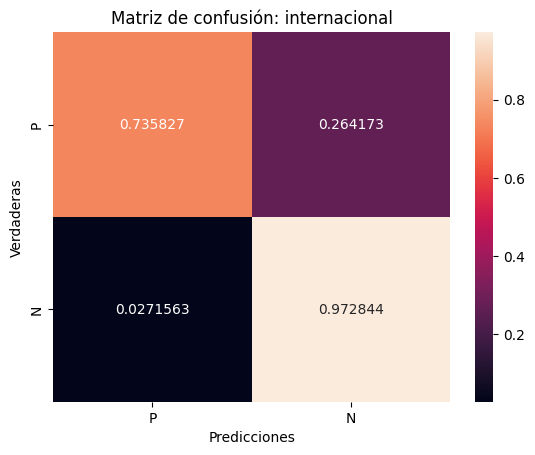

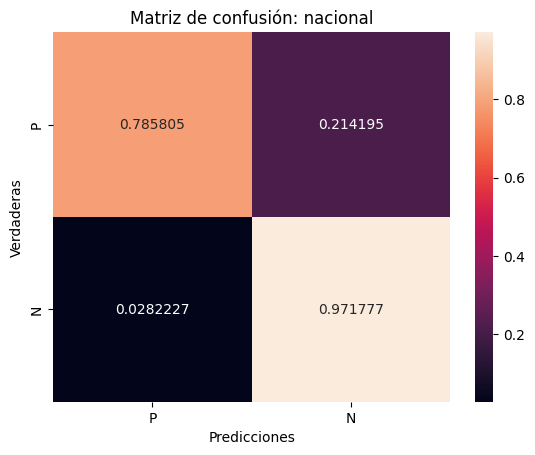

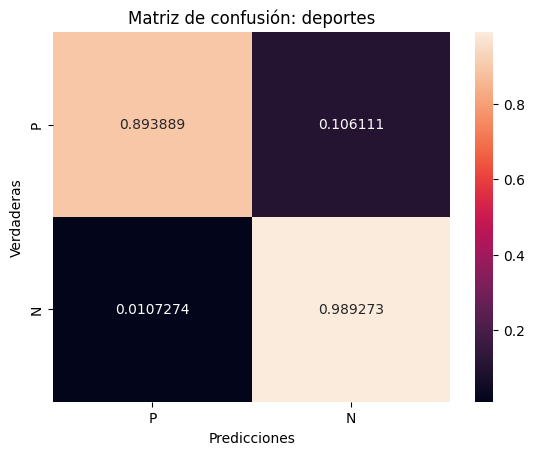

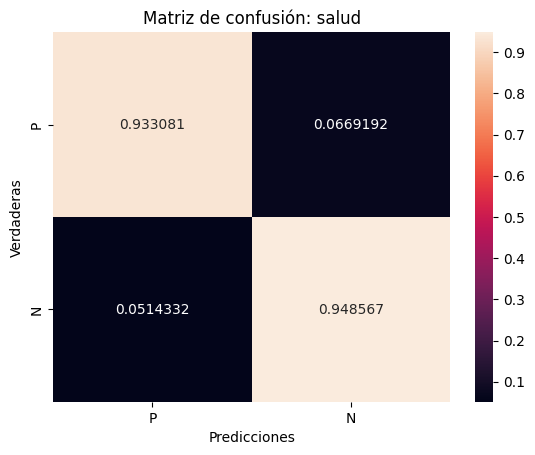

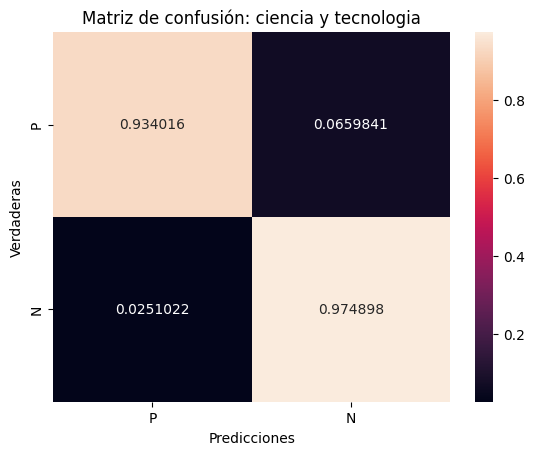

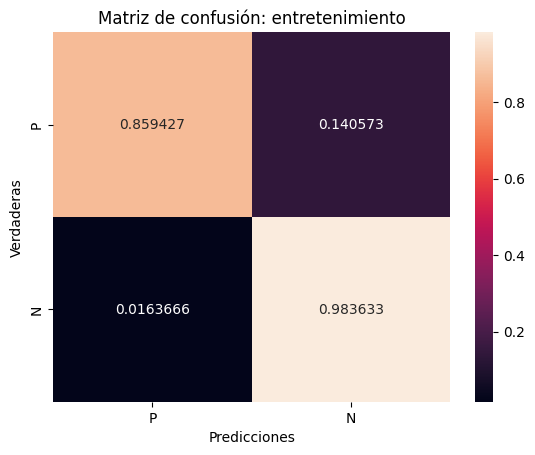

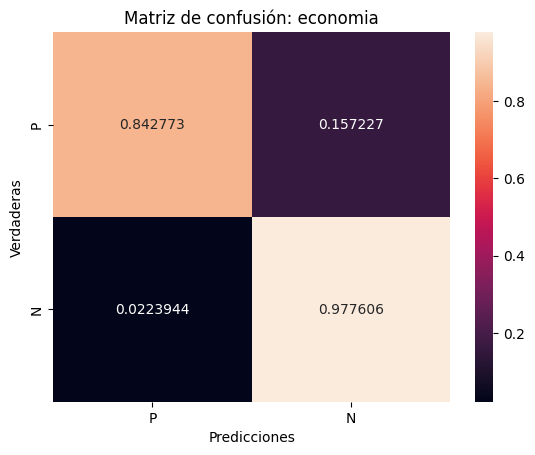

In [ ]:
P_N_categorias = matrices_confusion(df_test_copy)

## Métricas

In [ ]:
def metricas(dict_V_o_F):
  
  categorias = ["internacional","nacional","deportes","salud","ciencia y tecnologia","entretenimiento","economia"]
 
  # Diccionario donde cada categoria tiene un diccionario con sus metricas
  metricas_categorias = {
        'internacional': {'accuracy': 0, 'precision': 0, 'F1_score': 0, 'TVP': 0, 'TFP': 0},
        'nacional': {'accuracy': 0, 'precision': 0, 'F1_score': 0, 'TVP': 0, 'TFP': 0},
        'deportes': {'accuracy': 0, 'precision': 0, 'F1_score': 0, 'TVP': 0, 'TFP': 0},
        'salud': {'accuracy': 0, 'precision': 0, 'F1_score': 0, 'TVP': 0, 'TFP': 0},
        'ciencia y tecnologia': {'accuracy': 0, 'precision': 0, 'F1_score': 0, 'TVP': 0, 'TFP': 0},
        'entretenimiento': {'accuracy': 0, 'precision': 0, 'F1_score': 0, 'TVP': 0, 'TFP': 0},
        'economia': {'accuracy': 0, 'precision': 0, 'F1_score': 0, 'TVP': 0, 'TFP': 0},
    }

  # Utiliza como datos el diccionario previamente obtenido con los VP, FP, VN, FN

  for categoria in categorias: 
    VP = dict_V_o_F[categoria]['VP']
    FN = dict_V_o_F[categoria]['FN']
    FP = dict_V_o_F[categoria]['FP']
    VN = dict_V_o_F[categoria]['VN']

    # Calcular accuracy
    accuracy = (VP+VN)/(VP+VN+FN+FP)
    metricas_categorias[categoria]['accuracy'] = accuracy

    # Calcular precision
    precision = VP/(VP+FP)
    metricas_categorias[categoria]['precision'] = precision

    # Calcular TVP
    TVP = VP/(VP+FN)
    metricas_categorias[categoria]['TVP'] = TVP

    # Calcular F1-score
    F1_score = (2*precision*TVP)/(precision+TVP)
    metricas_categorias[categoria]['F1_score'] = F1_score

    # Calcular TFP
    TFP = FP/(FP+VN)
    metricas_categorias[categoria]['TFP'] = TFP

  # Graficos

  # Convertimos el diccionario a un dataframe para realizar el grafico de barras multiples
  df_metricas_categorias = pd.DataFrame([key for key in metricas_categorias.keys()], columns=['Categorías'])
  df_metricas_categorias['Accuracy'] = [value['accuracy'] for value in metricas_categorias.values()]
  df_metricas_categorias['Precision'] = [value['precision'] for value in metricas_categorias.values()]
  df_metricas_categorias['TVP'] = [value['TVP'] for value in metricas_categorias.values()]
  df_metricas_categorias['F1_score'] = [value['F1_score'] for value in metricas_categorias.values()]
  df_metricas_categorias['TFP'] = [value['TFP'] for value in metricas_categorias.values()]
  # Grafico realizado con función de Pandas (utiliza el DF)
  df_metricas_categorias.plot(x="Categorías", y=["Accuracy","Precision","TVP","F1_score","TFP"], kind="bar",figsize=(9,8),title="Métricas",ylim=(0,1.2)) 

  return metricas_categorias

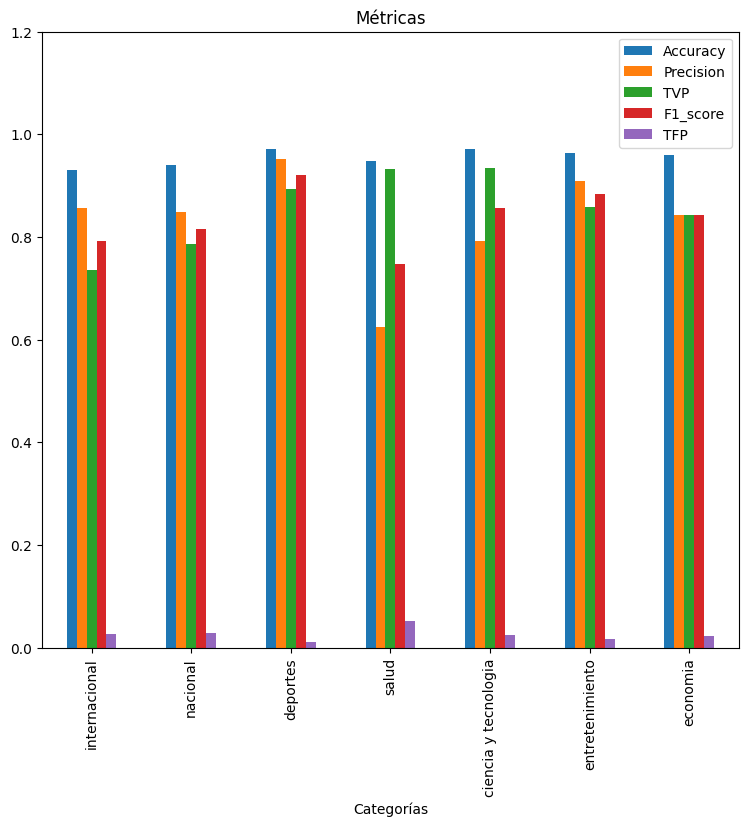

In [ ]:
metricas_categorias = metricas(P_N_categorias)

## Matriz de confusión completa

In [ ]:
def matriz_confusion(df_test):
  
  categorias = ["internacional","nacional","deportes","salud","ciencia y tecnologia","entretenimiento","economia"]

  categorias_codigos = {
        'internacional': '1',
        'nacional': '2',
        'deportes': '3',
        'salud': '4',
        'ciencia y tecnologia': '5',
        'entretenimiento': '6',
        'economia': '7',
    }

  # Diccionario en el cual cada categoria tiene un diccionario cuyas claves son las posiciones en la matriz
  # y los valores es la cantidad de titulares de esa categoria que fueron clasificados con esa categoria u otra
  metricas_categorias = { 
        'internacional': {'11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0},
        'nacional': {'21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 0, '27': 0},
        'deportes': {'31': 0, '32': 0, '33': 0, '34': 0, '35': 0, '36': 0, '37': 0},
        'salud': {'41': 0, '42': 0, '43': 0, '44': 0, '45': 0, '46': 0, '47': 0},
        'ciencia y tecnologia': {'51': 0, '52': 0, '53': 0, '54': 0, '55': 0, '56': 0, '57': 0},
        'entretenimiento': {'61': 0, '62': 0, '63': 0, '64': 0, '65': 0, '66': 0, '67': 0},
        'economia': {'71': 0, '72': 0, '73': 0, '74': 0, '75': 0, '76': 0, '77': 0},
    }

  # Hay que volver a calcular los VP, FN, VN y FP

  categorias_datos = df_test.categoria # Obtiene las categorias de los datos de prueba

  clasificacion_datos = df_test.clasificacion # Obtiene las clasificaciones de los datos de prueba

  for i in range(len(categorias_datos)):
    # Obtiene el codigo --> la posición en la matriz
    codigo = categorias_codigos[categorias_datos[i]] + categorias_codigos[clasificacion_datos[i]]
    metricas_categorias[categorias_datos[i]][codigo] += 1
    # if (categorias_datos[i] == clasificacion_datos[i]): # Si está bien clasificado --> diagonal
    #   # Obtiene el codigo --> la posición en la matriz
    #   codigo = categorias_codigos[categorias_datos[i]] + categorias_codigos[categorias_datos[i]]
    #   metricas_categorias[categorias_datos[i]][codigo] += 1
    # else: # Si está mal clasificado
    #   codigo = categorias_codigos[categorias_datos[i]] + categorias_codigos[clasificacion_datos[i]]
    #   metricas_categorias[categorias_datos[i]][codigo] += 1
  
  matriz_confusion = np.zeros((len(categorias_codigos), len(categorias_codigos))) 
  # Crea matriz de ceros con el mismo número de columnas y filas (num de categorias) --> 7x7

  # Carga los datos en la matriz utilizando los codigos del diccionario para acceder a los valores guardados
  # y para seleccionar la posición en la matriz donde se pondrán esos valores.
  for categoria in categorias:
    for categoria_2 in categorias:
      codigo = categorias_codigos[categoria] + categorias_codigos[categoria_2]
      matriz_confusion[int(categorias_codigos[categoria])-1, int(categorias_codigos[categoria_2])-1] = metricas_categorias[categoria][codigo]

  matriz_confusion_n = matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis] # Normalizacion de la matriz de confusion

  plt.figure(figsize=(20,20))
  # Grafico en forma de heatmap para tener colores
  sns.heatmap(matriz_confusion_n, annot=True, fmt='g', xticklabels = categorias, yticklabels = categorias)
  plt.title("Matriz de confusión")
  plt.xlabel("Predicciones")
  plt.ylabel("Verdaderas")
  plt.show()

  return 

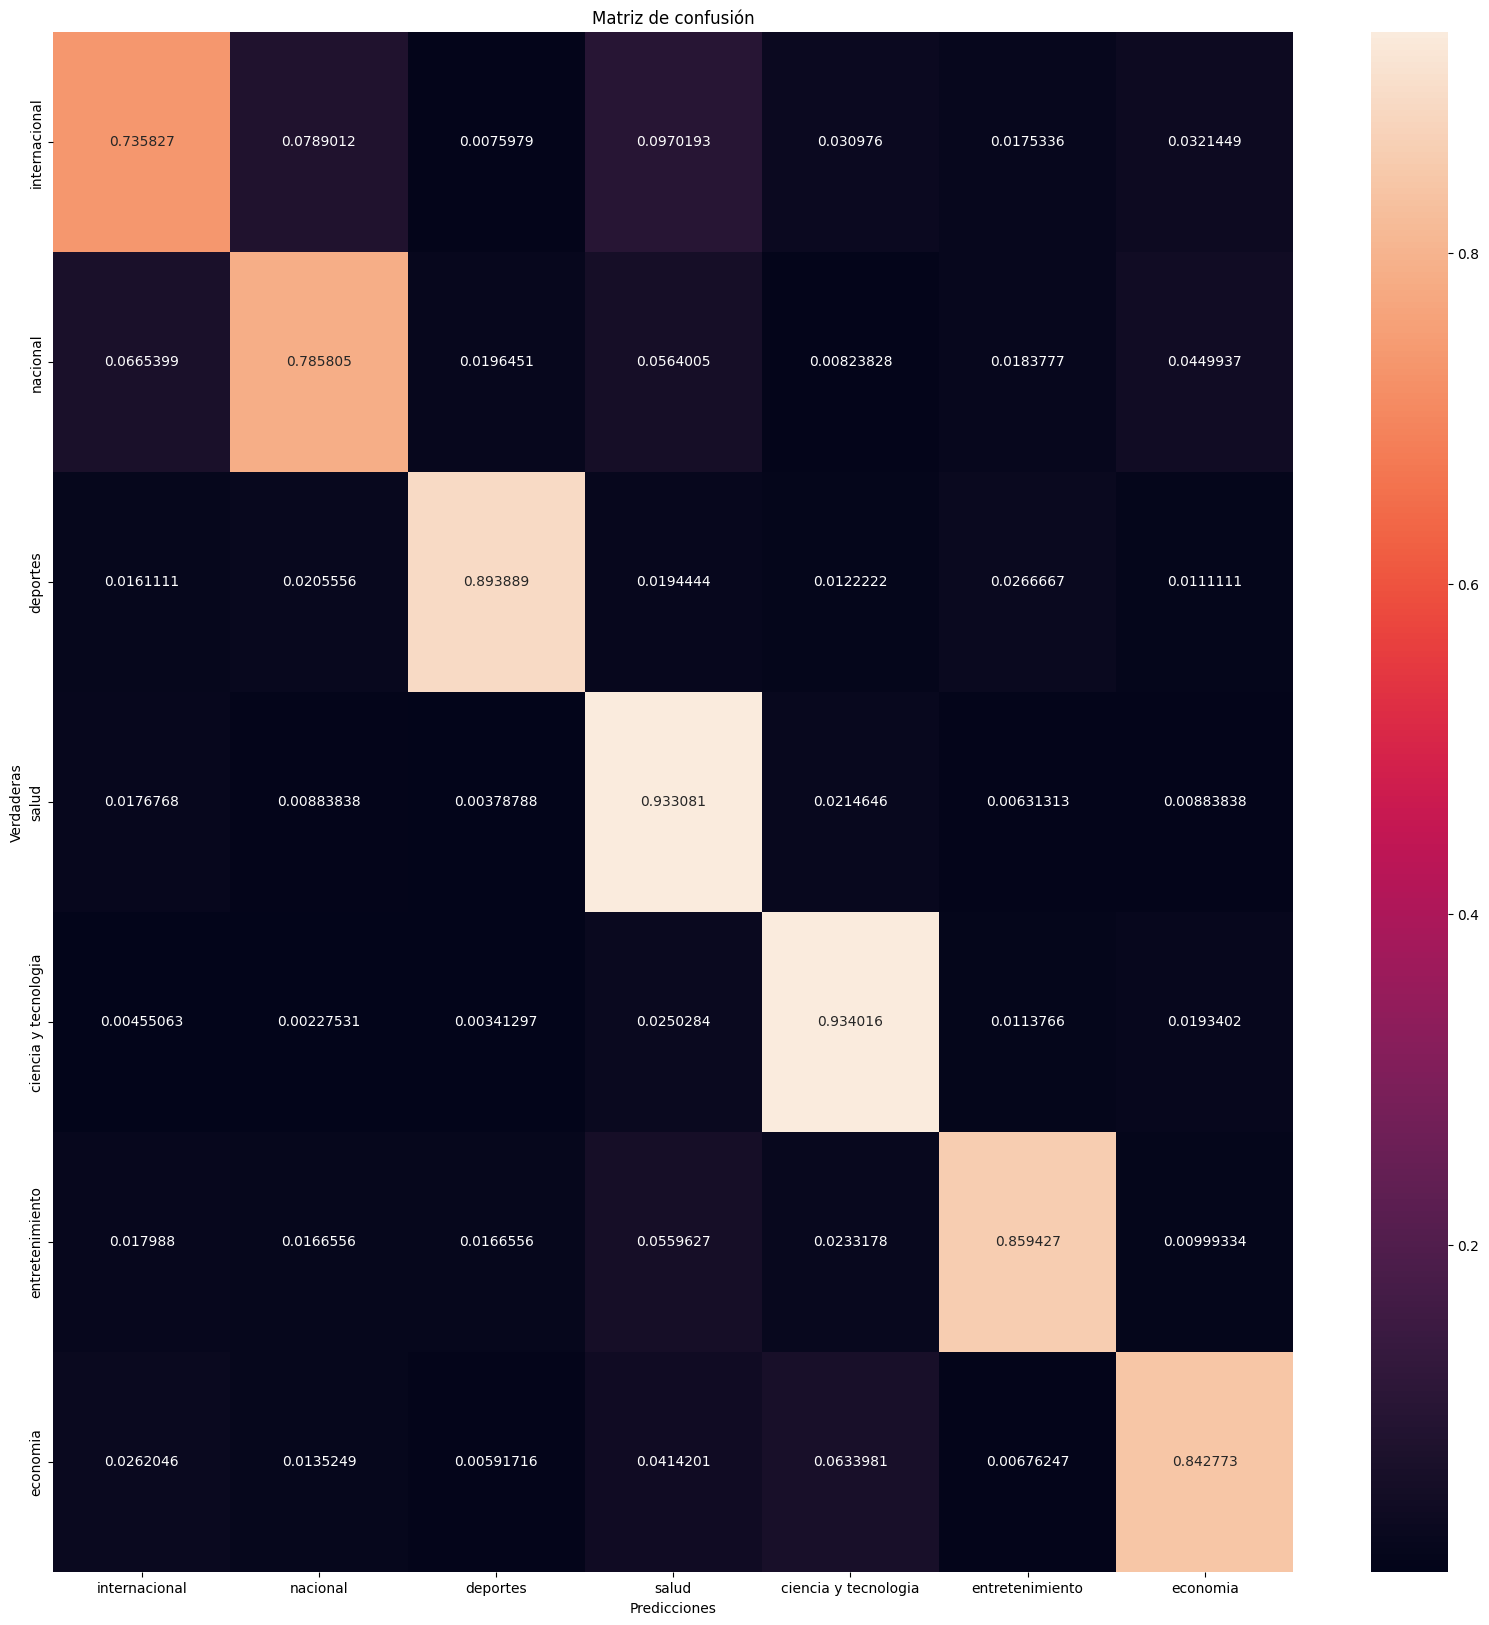

In [ ]:
matriz_confusion(df_test_copy)

Para confirmar que las cuentas de la matriz de confusión son correctas, se utilizó la funcion *confusion_matrix* de la librería **sklearn**.

In [ ]:
categorias_datos = df_test_copy.categoria

clasificacion_datos = df_test_copy.clasificacion

matriz_sklearn = confusion_matrix(categorias_datos, clasificacion_datos, labels = ["internacional","nacional","deportes","salud","ciencia y tecnologia","entretenimiento","economia"], normalize = "true")

print(matriz_sklearn)

[[0.735827   0.07890123 0.0075979  0.09701929 0.03097604 0.01753361
  0.03214494]
 [0.06653992 0.78580482 0.01964512 0.05640051 0.00823828 0.01837769
  0.04499366]
 [0.01611111 0.02055556 0.89388889 0.01944444 0.01222222 0.02666667
  0.01111111]
 [0.01767677 0.00883838 0.00378788 0.93308081 0.02146465 0.00631313
  0.00883838]
 [0.00455063 0.00227531 0.00341297 0.02502844 0.93401593 0.01137656
  0.01934016]
 [0.01798801 0.01665556 0.01665556 0.05596269 0.02331779 0.85942705
  0.00999334]
 [0.02620456 0.01352494 0.00591716 0.04142012 0.06339814 0.00676247
  0.84277261]]


## Curva ROC

In [ ]:
def curva_ROC(df_test):
  # Utiliza los datos de prueba

  categorias_datos = df_test.categoria

  clasificacion_datos = df_test.clasificacion

  probs_datos = df_test.probabilidades # Probabilidades reales

  umbrales_array = np.linspace(0,1,11) # Se crea un array con 11 umbrales entre 0 y 1 uniformemente espaciados 

  umbrales = umbrales_array.tolist() # Pasa el array a lista para mejor manipulación

  # Se crea una matriz para cada categoria
  # filas: umbrales, columnas: VP, VN, FP, FN
  matriz_umbrales_internacional = np.zeros([11,4]) 
  matriz_umbrales_nacional = np.zeros([11,4])
  matriz_umbrales_deportes = np.zeros([11,4]) 
  matriz_umbrales_salud = np.zeros([11,4])
  matriz_umbrales_cyt = np.zeros([11,4])
  matriz_umbrales_entretenimiento = np.zeros([11,4])
  matriz_umbrales_economia = np.zeros([11,4])

  # Guardamos todas las matrices en una sola por comodidad
  matrices_umbrales = [matriz_umbrales_internacional, matriz_umbrales_nacional, matriz_umbrales_deportes, matriz_umbrales_salud, matriz_umbrales_cyt, matriz_umbrales_entretenimiento, matriz_umbrales_economia]

  categorias = ["internacional","nacional","deportes","salud","ciencia y tecnologia","entretenimiento","economia"]

  categorias_codigos = {
        'internacional': 0,
        'nacional': 1,
        'deportes': 2,
        'salud': 3,
        'ciencia y tecnologia': 4,
        'entretenimiento': 5,
        'economia': 6,
    }

  for i in range(len(categorias_datos)): # Para cada titular
    prob = probs_datos[i] # prob = [...,...,...,...,...,...,...]
    for umbral in umbrales:
      for k in range(7): # Para cada probabilidad del titular
        if prob[k] >= umbral: # Clasificó como que pertenece a la categoria analizada
          if categorias_datos[i] == categorias[k]:
            # Categoria real es igual a la categoria analizada
            matrices_umbrales[k][umbrales.index(umbral)][0] += 1 # VP
          else:
            # Categoria real es distinta a la analizada
            matrices_umbrales[k][umbrales.index(umbral)][2] += 1 # FP
        else: # Clasificó como que no pertenece a la categoria analizada --> prob < umbral
          if categorias_datos[i] == categorias[k]: 
            # Categoria real es igual a la categoria analizada --> era de esa categoria!
            matrices_umbrales[k][umbrales.index(umbral)][3] += 1 # FN
          else:
            # Categoria real es distinta a la analizada --> no era de esa categoria!
            matrices_umbrales[k][umbrales.index(umbral)][1] += 1 # VN

  plt.figure(figsize=(20,15))
  
  # Calcular TVP, TFP y areas

  categorias_print = ["Internacional","Nacional","Deportes","Salud","Ciencia y Tecnología","Entretenimiento","Economía"]

  areas = []

  for i in range(7): # Para cada categoria calcula TVP, TFP y area
    valores_TVP = []
    valores_TFP = []

    for j in range(11): # Para cada umbral
      # Calcular TVP
      # TVP = VP/(VP+FN)
      TVP = matrices_umbrales[i][j][0] / (matrices_umbrales[i][j][0] + matrices_umbrales[i][j][3])
      valores_TVP.append(TVP)

      # Calcular TFP
      # TFP = FP/(FP+VN)
      TFP = matrices_umbrales[i][j][2] / (matrices_umbrales[i][j][2] + matrices_umbrales[i][j][1])
      valores_TFP.append(TFP)

    # Calcular area
    # https://www.mathworks.com/help/matlab/ref/trapz.html
    area = -np.trapz(valores_TVP, valores_TFP) # Integracion numérica por método trapezoidal 

    areas.append(area) # Se guardan todas las áreas para imprimir

    # Graficar curva ROC para cada categoria en un mismo gráfico
    plt.plot(valores_TFP, valores_TVP, linestyle='solid', linewidth = 2, marker='o', markersize=7, label=categorias_print[i])
  
  # Graficar x=y
  x1 = [0,1]
  y1 = [0,1]
  plt.plot(x1, y1, color='grey', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='grey', markersize=2)
  plt.title("Curva ROC")
  plt.xlabel('Tasa de Falsos Positivos')
  plt.ylabel('Tasa de Verdaderos Positivos')
  ###
  # Para cambiar límites de los ejes
  # plt.xlim(0,1)
  # plt.ylim(0,1.05)
  plt.xlim(0,0.1)
  plt.ylim(0.5,1)
  ###
  plt.legend()
  plt.show()

  return matrices_umbrales, areas

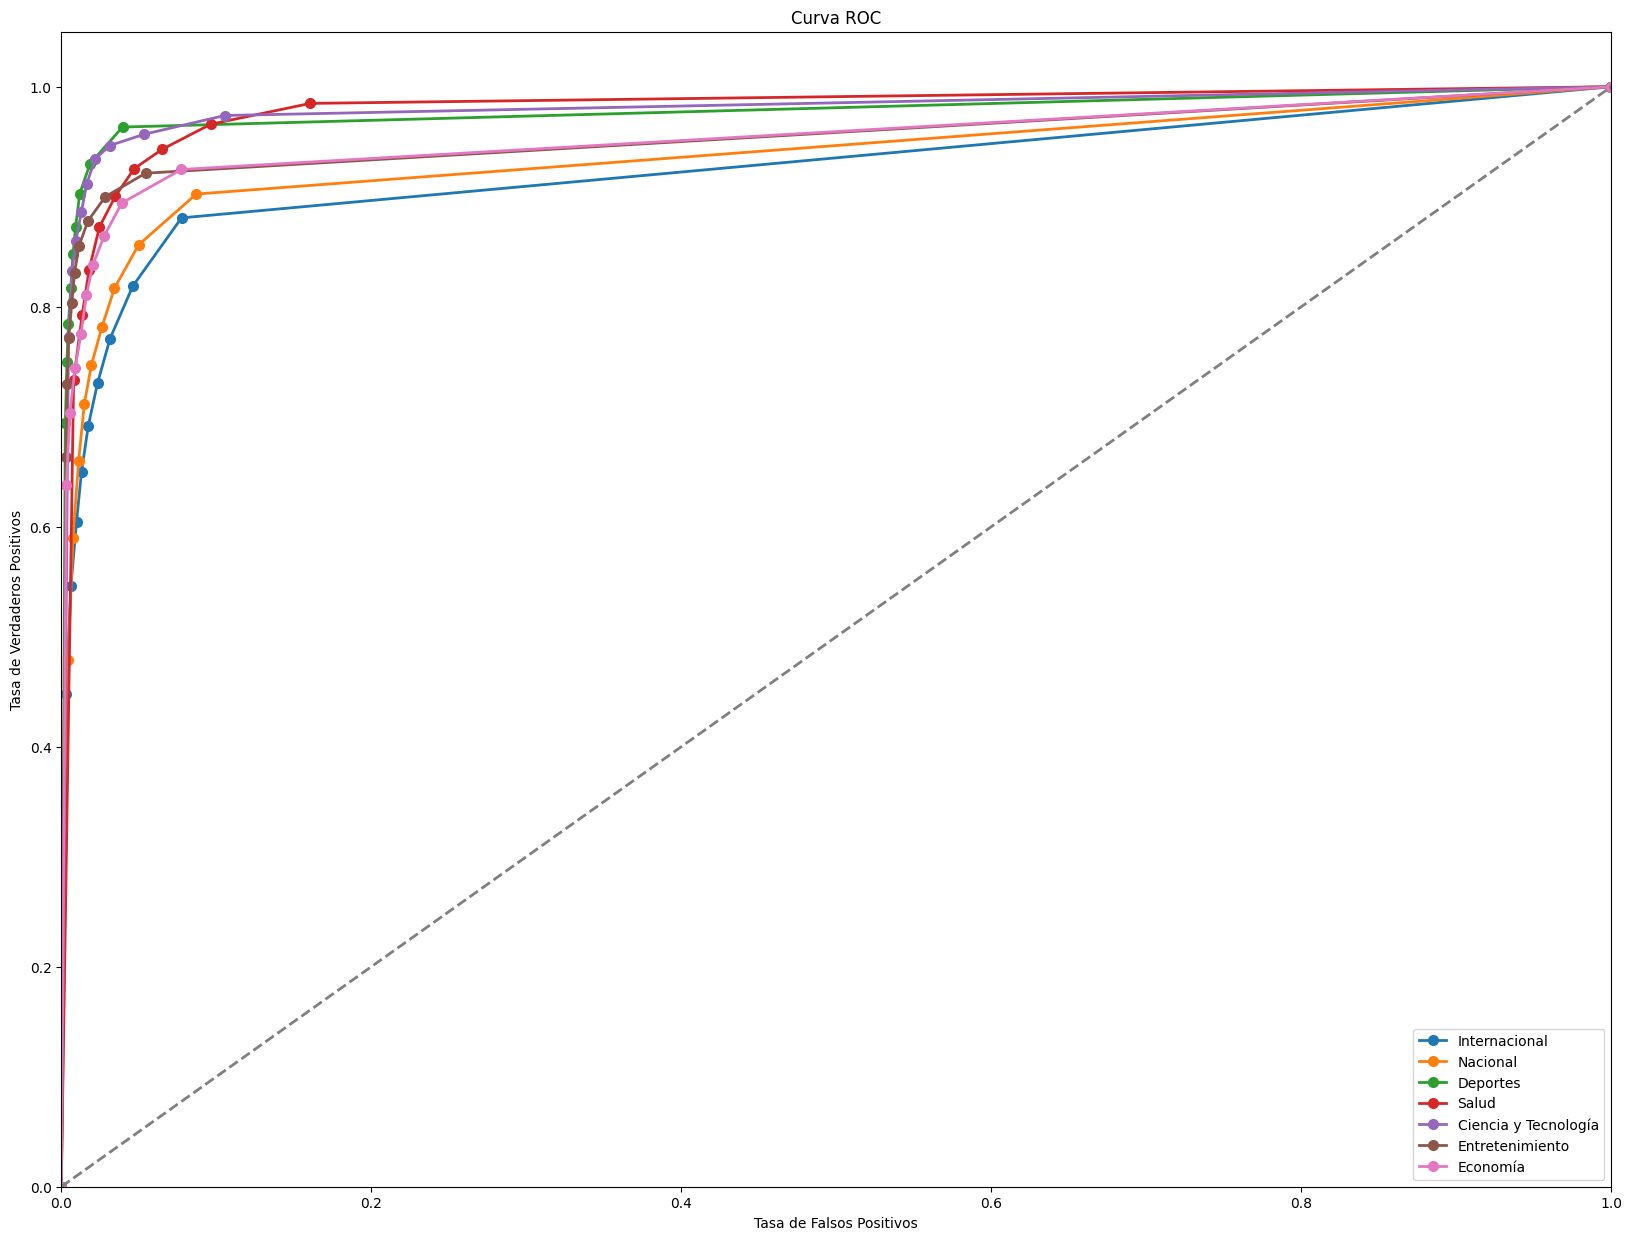

In [ ]:
matrices_umbrales, areas = curva_ROC(df_test_copy)

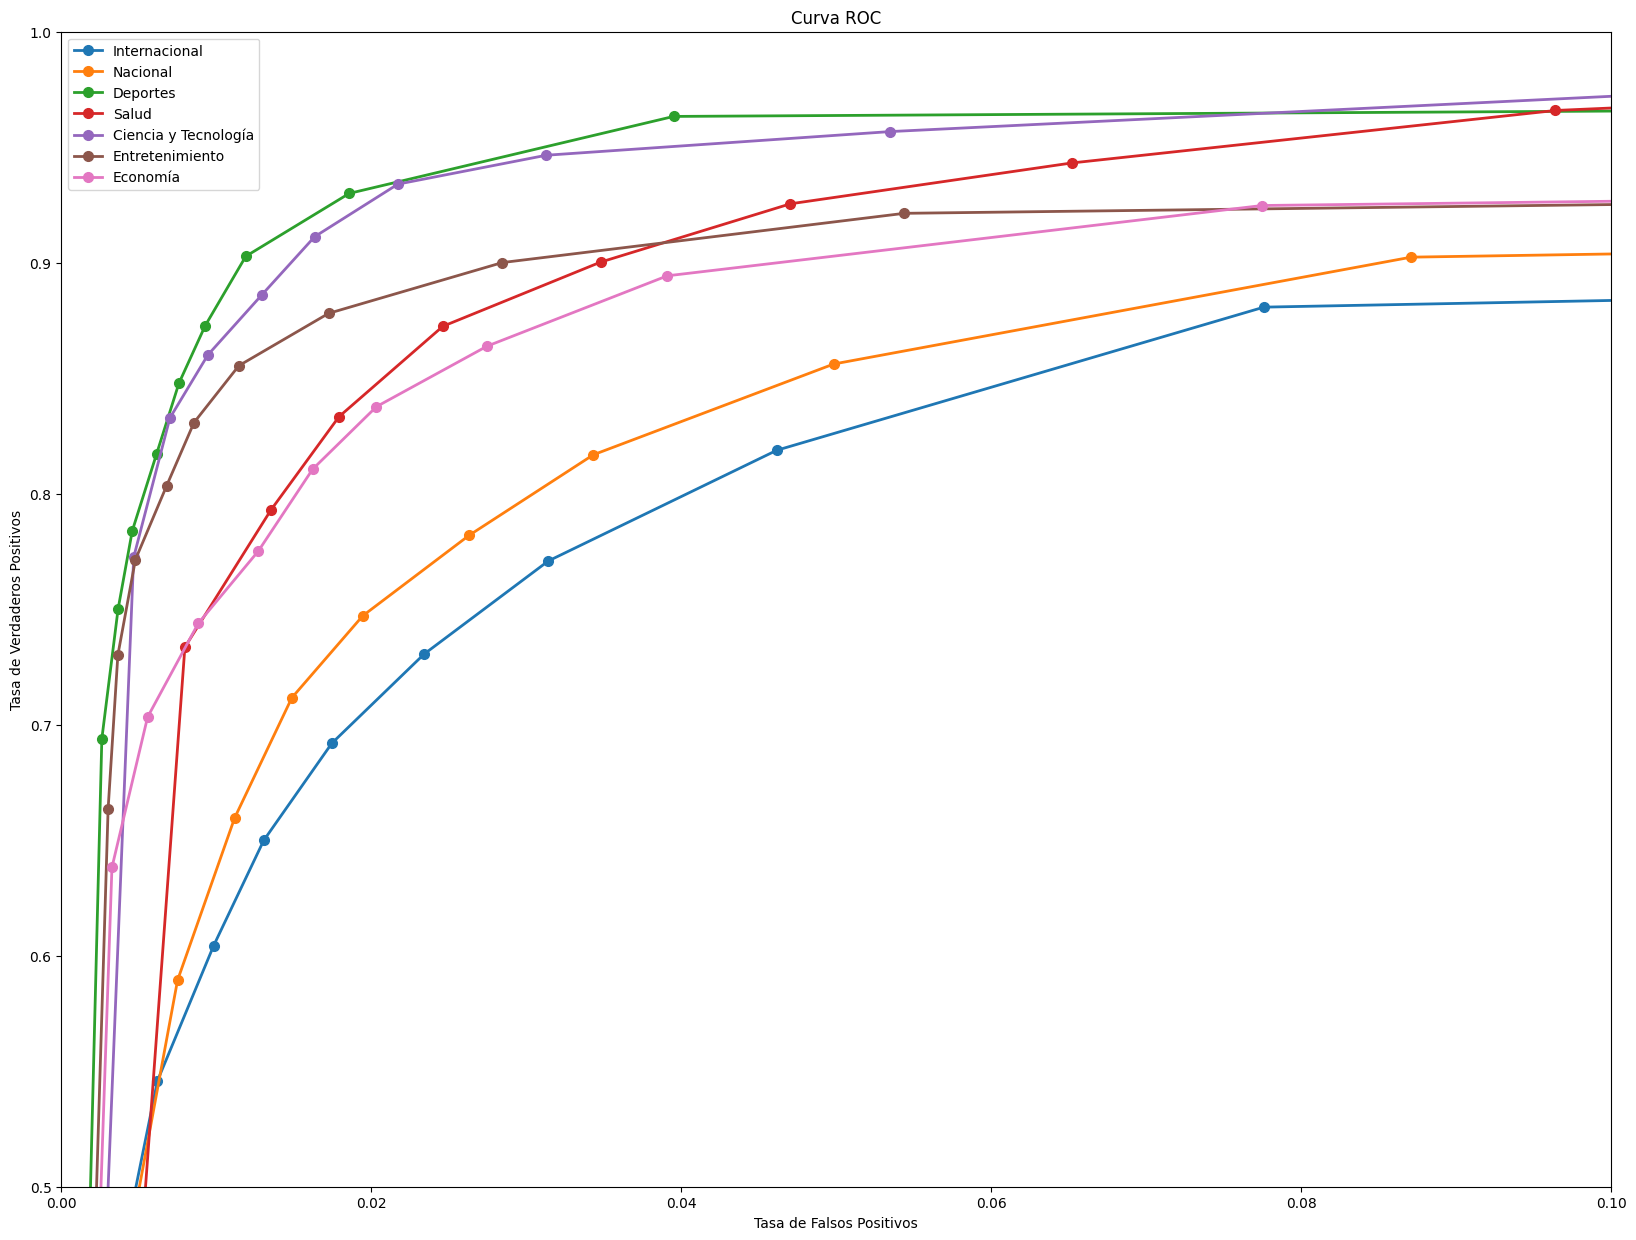

In [ ]:
matrices_umbrales, areas = curva_ROC(df_test_copy)

In [ ]:
print(areas)
# categorias = ["internacional","nacional","deportes","salud","ciencia y tecnologia","entretenimiento","economia"]

[0.9253543320417109, 0.9366094697075894, 0.9774183092040235, 0.9790559752634995, 0.9799426456455919, 0.9548038937992824, 0.9530885994063296]
